In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Import the relevant models - random forest and others for comparison:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier




In [2]:
rw = pd.read_csv('C:\Asus WebStorage\psabin@gmail.com\MySyncFolder\Data Science Course\BlueBerry Winery\winequality-white.csv', sep=';')

rw['quality_label'] = rw['quality'].apply(lambda value: 'low'
if value <= 5 else 'medium'
if value <= 7 else 'high')

# Transforming these labels into categrical data type instead of string
rw['quality_label'] = pd.Categorical(rw['quality_label'],
categories=['low', 'medium', 'high'])

# Encode quality labels as numbers
le = LabelEncoder()
rw['encoded_quality_label'] = le.fit_transform(rw['quality_label'])  

# Swap 0 for 3 to make the order make sense from low to high
rw['encoded_quality_label'].replace(0,3,inplace=True)

# Drop quality 1-10 and low-high columns
rw.drop(['quality_label'], axis=1, inplace=True)
rw.drop(['quality'], axis=1, inplace=True)

# Create column vector for encoded quality label
y_rw_quality = rw.encoded_quality_label


In [3]:
# Select ALL features
rw_select = rw.drop(['encoded_quality_label'], axis=1)
# Split data
rw_features_train, rw_features_test, rw_quality_train, rw_quality_test = train_test_split(rw_select,y_rw_quality,test_size=0.2, random_state=19)
# Scale features
scaler = StandardScaler()
rw_features_train_scaled = scaler.fit_transform(rw_features_train)
rw_features_test_scaled = scaler.transform(rw_features_test)

In [4]:
def randomized_searchCV(model, X_train, y_train):


    # Define hyperparameter search space
    param_dist = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
    }

    # Create RandomizedSearchCV object
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=50, scoring='accuracy', cv=5)

    # Fit the object to the data
    random_search.fit(X_train, y_train)

    # Get best hyperparameter combination
    best_params = random_search.best_params_

    return best_params

# Define the model
random_forest = RandomForestClassifier()

# Call the function with out training data
randomized_searchCV(random_forest, rw_features_train_scaled, rw_quality_train)

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'entropy',
 'bootstrap': True}

In [5]:
forest_best_params = {'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'entropy',
 'bootstrap': True}

In [6]:
def model_accuracy_comparison(X_train, y_train, X_test, y_test):
    # Create an array of classification models (classifiers)
    classifiers = [
        ('Random Forest Tuned', RandomForestClassifier(**forest_best_params)),
        ('Random Forest', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)),
        ('Decision Tree', DecisionTreeClassifier(criterion = 'gini', random_state = 0)),
        ('Support Vector Classification', SVC()),
        ('Neural Network', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, learning_rate_init=0.001, early_stopping=True, activation='relu', solver='adam', random_state=0)),
        
    ]
    # Create a figure to accommodate the heatmaps for each model
    fig, axs = plt.subplots(1, len(classifiers), figsize=(16, 3))
    
    metrics_df = pd.DataFrame(columns=['Classifier', 'Test Accuracy', 'Train Accuracy', 'Precision', 'Recall', 'F1-Score'])

    for idx, (name, clf) in enumerate(classifiers):
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_train)
        test_predictions = clf.predict(X_test)
        
        # Calculate metrics
        train_accuracy = (accuracy_score(y_train, train_predictions) * 100).round(2)
        test_accuracy = (accuracy_score(y_test, test_predictions) * 100).round(2)
        precision = (precision_score(y_test, test_predictions, average='weighted') * 100).round(2)
        recall = (recall_score(y_test, test_predictions, average='weighted') * 100).round(2)
        f1 = (f1_score(y_test, test_predictions, average='weighted') * 100).round(2)
        cohen_kappa = cohen_kappa_score(y_test, test_predictions).round(2)
        
        # Create confusion matrix and heatmap of it
        cm = confusion_matrix(y_test, test_predictions)

        # Create a mask for off-diagonal cells
        mask = np.ones_like(cm, dtype=bool)
        np.fill_diagonal(mask, 0)

        bleh_green_palette = sns.diverging_palette(70, 100, s=100, l=50, as_cmap=True)
        correct_cmap = sns.color_palette("viridis_r", as_cmap=True)
        green_palette = sns.color_palette(palette='Greens_d')
        summer_palette = sns.color_palette(palette='summer_r')
        incorrect_cmap = sns.color_palette("flare", as_cmap=True)

        
        # Plot the heatmap with the mask
        sns.heatmap(cm, annot=True, fmt="d", cmap=summer_palette, mask=mask, cbar=False, ax=axs[idx])
        sns.heatmap(cm, annot=True, fmt="d", cmap=incorrect_cmap, mask=~mask, cbar=False, ax=axs[idx], vmax=cm.max())
        axs[idx].set_title(name)
        axs[idx].set_xlabel('Predicted labels')
        axs[idx].set_ylabel('True labels')

        metrics_row = {
            'Classifier': name,
            'Test Accuracy': test_accuracy,
            'Train Accuracy': train_accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            "Cohen's Kappa": cohen_kappa
        }

        metrics_df = pd.concat([metrics_df, pd.DataFrame([metrics_row])]).reset_index(drop=True)
        metrics_df = metrics_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
    
    # Display the heatmap visualization
    plt.tight_layout()
    plt.show()

    display(metrics_df)

c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\psabi\anaconda3\envs\CAB\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


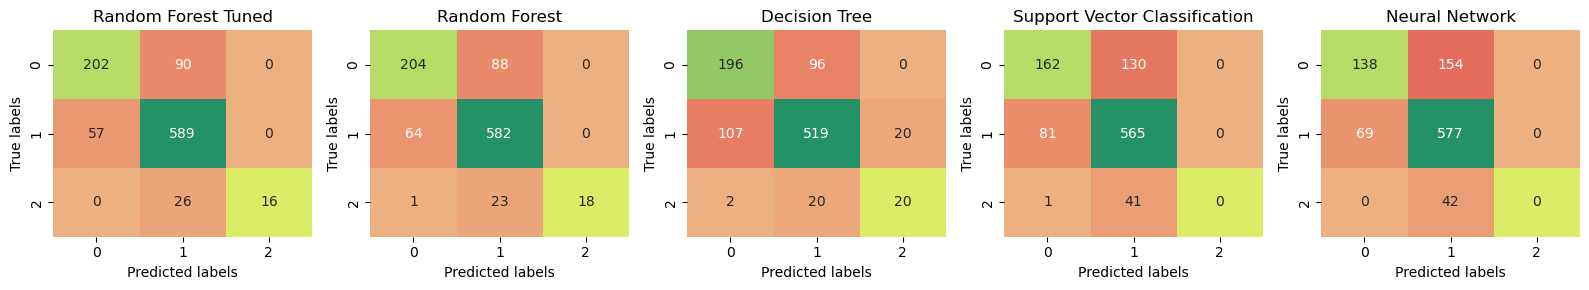

,Classifier,Test Accuracy,Train Accuracy,Precision,Recall,F1-Score,Cohen's Kappa
0,Random Forest Tuned,82.35,99.64,82.60,82.35,81.69,0.60
1,Random Forest,82.04,100.00,82.24,82.04,81.54,0.60
2,Decision Tree,75.00,100.00,75.17,75.00,75.07,0.48
3,Support Vector Classification,74.18,77.62,70.39,74.18,71.91,0.40
4,Neural Network,72.96,72.28,69.07,72.96,70.09,0.35


In [7]:
model_accuracy_comparison(rw_features_train_scaled, rw_quality_train, rw_features_test_scaled, rw_quality_test)